In [33]:
import scipy.io as sio

def readQTMFile(qtmFile):
    content = sio.loadmat(qtmFile)
    
    index = 0
    mat_var_index = 0
    for key in content.keys(): 
        index = key.find('__') #the variable in the matlab file is the first key that don't have this chars
        if index == -1:
            break
        mat_var_index += 1

    if index != -1:
        raise ValueError("File format wrong. It does not have the initial variable")

    root_var = content[content.keys()[mat_var_index]][0,0] 
    trajectories = root_var['Trajectories'][0,0]['Unidentified'][0,0]['Data']
    new_content = {
            'frame_rate': root_var['FrameRate'][0,0], 
            'trajectories': trajectories,
            'frames': root_var['Frames'][0,0],
            'number_markers': trajectories.shape[0] 
            }
    
    return new_content


In [34]:
data = readQTMFile("data/JULIANA2701w1U.mat")

In [35]:
positional_data = {}
positional_data['patient_id'] = 0
positional_data['gait_sample_index'] = 0
positional_data['frame_rate'] = data['frame_rate']

positional_data['frames'] = data['frames']
positional_data['number_markers'] = data['number_markers']
positional_data['original_filename'] = "JULIANA2701w1U.mat"

#Precisa configurar
positional_data['initial_frame'] = 55
positional_data['final_frame'] = 110


markers = [];
for i in range(data['number_markers']):
        markers.append('')
positional_data['markers'] = markers
positional_data['trajectories'] = data['trajectories'].tolist()
    
    
    #markers
positional_data['markers'][8] = 'Right Subtalar'
positional_data['markers'][11] = 'Right Knee'
positional_data['markers'][21] = 'Right Trochanter'
positional_data['markers'][7] = 'Right Tibia'
positional_data['markers'][5] = 'Sacrum'
positional_data['markers'][3] = 'Left Subtalar'
positional_data['markers'][10] = 'Left Knee'
positional_data['markers'][22] = 'Left Trochanter'
positional_data['markers'][18] = 'Left Tibia'

In [36]:
import numpy as np
def cut_trajectories(pos):
    trajectories = np.array(pos['trajectories'])
    if 'initial_frame' in pos and 'final_frame' in pos and 'frames' in pos:
        initial = pos['initial_frame'] 
        final = pos['final_frame']
        frames = pos['frames'] 
        if initial >0 and initial < final and final < frames:
            trajectories = trajectories[:,:, initial:final]
    return trajectories


#cinematic

def calc_angular_velocities(origins, components_a, components_b, time):
    angles = get_angles(origins, components_a, components_b)
    final = angles[1: len(angles)]
    initial = angles[0: len(angles) -1]
    return (final - initial) / time

def calc_angular_accelerations(angular_velocities, time):
    final = angular_velocities[1: len(angular_velocities)]
    initial = angular_velocities[0: len(angular_velocities) -1]
    return (final - initial) / time


def get_angles(origins, components_a, components_b):
    trans_a = components_a - origins
    trans_b = components_b - origins
    angles = np.arccos(np.sum(trans_a * trans_b, axis = 1)/(np.sqrt(np.sum(trans_a ** 2, axis = 1)) * np.sqrt(np.sum(trans_b ** 2, axis = 1))))

    return (np.pi -  angles) * (180/np.pi)

def get_vectorial_velocities(vector, time):
        final_position = vector[1: len(vector)]
        initial_position = vector[0: len(vector) - 1]
        return (final_position - initial_position) / time

def get_3d_velocities(vector_x, vector_y, vector_z, time):
        return (get_vectorial_velocities(vector_x, time), get_vectorial_velocities(vector_y, time), get_vectorial_velocities(vector_z, time))
    
def calc_pos_foot_center(sacrum, subtalar):

    for i in range(len(sacrum[0])):
        if i == 0:
            comp_x = [(sacrum[0][i]).T - (subtalar_r[0][i]).T]
            comp_y = [(sacrum[1][i]).T - (subtalar_r[1][i]).T]
            comp_z = [(sacrum[2][i]).T - (subtalar_r[2][i]).T]
            pos = np.sqrt([np.power(comp_x,[2])+np.power(comp_y,[2])+np.power(comp_z,[2])])
        if i > 0:
            comp_x = [(sacrum[0][i]).T - (subtalar_r[0][i]).T]
            comp_y = [(sacrum[1][i]).T - (subtalar_r[1][i]).T]
            comp_z = [(sacrum[2][i]).T - (subtalar_r[2][i]).T]
            pos = np.concatenate((pos, np.sqrt([np.power(comp_x,[2])+np.power(comp_y,[2])+np.power(comp_z,[2])])), axis=0)
    return pos

In [37]:
#Colocando os dados dentro do ciclo de marcha
cut_t = cut_trajectories(positional_data)

#posição dos pés relativa ao Sacro
sacrum = cut_t[5][0:3][:]
subtalar_r = cut_t[8][0:3][:]
subtalar_l = cut_t[3][0:3][:]

#angulo joelho direito
origin = cut_t[11][0:3][:]       #Joelho
component_a = cut_t[21][0:3][:]  #Trocanter
component_b = cut_t[7][0:3][:]   #Tibia

#angulo joelho esquerdo
l_origin = cut_t[10][0:3][:] #joelho
l_component_a = cut_t[22][0:3][:]#Trocanter
l_component_b = cut_t[18][0:3][:]  #Tibia

In [38]:
#features da perna direita
a = get_angles(
        np.array(origin).T, 
        np.array(component_a).T, 
        np.array(component_b).T)
av = calc_angular_velocities(np.array(origin).T, 
                             np.array(component_a).T, 
                             np.array(component_b).T, 
                             1/float(positional_data['frame_rate']))  
aa = calc_angular_accelerations(av, 1/float(positional_data['frame_rate']))
# as velocidades vem do trocanter
velocities3d = np.vstack(get_3d_velocities(component_a.T[:,0], 
                                 component_a.T[:,1],
                                 component_a.T[:,2],                                 
                                 1/float(positional_data['frame_rate']))).T

#features da perna esquerda

l_a = get_angles(
        np.array(l_origin).T, 
        np.array(l_component_a).T, 
        np.array(l_component_b).T)
l_av = calc_angular_velocities(np.array(l_origin).T, 
                             np.array(l_component_a).T, 
                             np.array(l_component_b).T, 
                             1/float(positional_data['frame_rate']))  
l_aa = calc_angular_accelerations(l_av, 1/float(positional_data['frame_rate']))
# as velocidades vem do trocanter
l_velocities3d = np.vstack(get_3d_velocities(l_component_a.T[:,0], 
                                 l_component_a.T[:,1],
                                 l_component_a.T[:,2],                                 
                                 1/float(positional_data['frame_rate']))).T

# posição do pé direito em relação ao sacro
pos_foot_r = calc_pos_foot_center(sacrum, subtalar_r)

# posição do pé esquerdo em relação ao sacro
pos_foot_l = calc_pos_foot_center(sacrum, subtalar_l)

In [39]:
## salvando em arquivo na pasta 
from Data_Savior import save_it_now
save_it_now(a, av, aa, velocities3d, l_a, l_av, l_aa, l_velocities3d, "./preprocessed_data/JULIANA2701w1U.data")

Saved to file


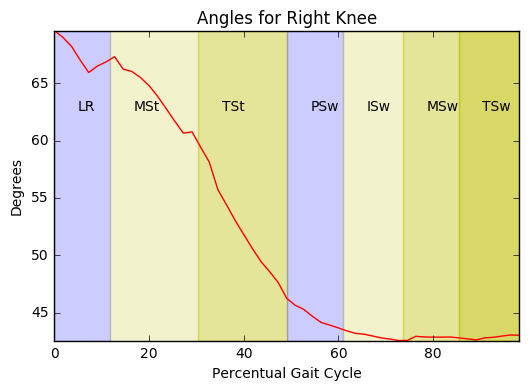

In [40]:
%matplotlib inline
a_img = a 
a_dom = 100 * np.arange(0, len(a_img))/np.float(len(a_img))
lr_i = 0
lr_f = a_dom.max() * 0.12 
mst_i = lr_f
mst_f = a_dom.max() * 0.31
tst_i = mst_f
tst_f = a_dom.max() * 0.50
psw_i = tst_f
psw_f = a_dom.max() * 0.62
isw_i = psw_f
isw_f = a_dom.max() * 0.75
msw_i = isw_f
msw_f = a_dom.max() * 0.87
tsw_i = msw_f
tsw_f = a_dom.max() * 1


import matplotlib.pyplot as plt
fig = plt.figure(1)

plt.subplot(1,1,1)
plt.title("Angles for %s" % "Right Knee")
plt.ylabel ("Degrees")
plt.xlabel ("Percentual Gait Cycle")
plt.axis([0, a_dom.max(), a_img.min(), a_img.max()])
curve_a, = plt.plot(a_dom, a_img, 'r')
plt.axvspan(xmin = lr_i, xmax=lr_f, ymin =0, ymax=1, alpha = 0.2, color='b')
plt.annotate('LR', xy=(lr_i + 5, a_img.max() * 0.90))  
plt.axvspan(xmin = mst_i, xmax=mst_f, ymin =0, ymax=1, alpha = 0.2, color='y')
plt.annotate('MSt', xy=(mst_i + 5, a_img.max() * 0.90))  
plt.axvspan(xmin = tst_i, xmax=tst_f, ymin =0, ymax=1, alpha = 0.4, color='y')
plt.annotate('TSt', xy=(tst_i + 5, a_img.max() * 0.90))  
plt.axvspan(xmin = psw_i, xmax=psw_f, ymin =0, ymax=1, alpha = 0.2, color='b')
plt.annotate('PSw', xy=(psw_i + 5, a_img.max() * 0.90))  
plt.axvspan(xmin = isw_i, xmax=isw_f, ymin =0, ymax=1, alpha = 0.2, color='y')
plt.annotate('ISw', xy=(isw_i + 5, a_img.max() * 0.90))  
plt.axvspan(xmin = msw_i, xmax=msw_f, ymin =0, ymax=1, alpha = 0.4, color='y')
plt.annotate('MSw', xy=(msw_i + 5, a_img.max() * 0.90))  
plt.axvspan(xmin = tsw_i, xmax=tsw_f, ymin =0, ymax=1, alpha = 0.6, color='y')
plt.annotate('TSw', xy=(tsw_i + 5, a_img.max() * 0.90))  

plt.show()

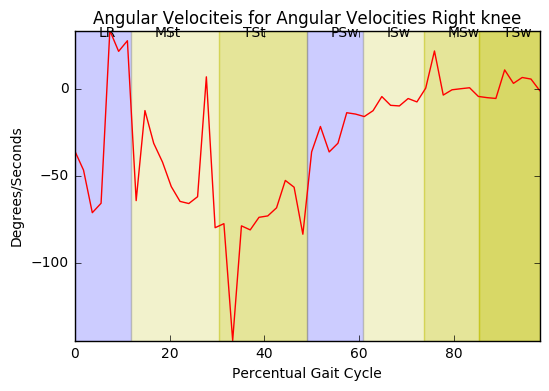

In [41]:

av_img = av 
av_dom = 100 * np.arange(0, len(av_img))/np.float(len(av_img))
lr_i = 0
lr_f = av_dom.max() * 0.12 
mst_i = lr_f
mst_f = av_dom.max() * 0.31
tst_i = mst_f
tst_f = av_dom.max() * 0.50
psw_i = tst_f
psw_f = av_dom.max() * 0.62
isw_i = psw_f
isw_f = av_dom.max() * 0.75
msw_i = isw_f
msw_f = av_dom.max() * 0.87
tsw_i = msw_f
tsw_f = av_dom.max() * 1

import matplotlib.pyplot as plt
fig = plt.figure(1)

plt.subplot(1,1,1)
plt.title("Angular Velociteis for %s" % "Angular Velocities Right knee")
plt.ylabel ("Degrees/Seconds")
plt.xlabel ("Percentual Gait Cycle")
plt.axis([0, av_dom.max(), av_img.min(), av_img.max()])
curve_av, = plt.plot(av_dom, av_img, 'r')
plt.axvspan(xmin = lr_i, xmax=lr_f, ymin =0, ymax=1, alpha = 0.2, color='b')
plt.annotate('LR', xy=(lr_i + 5, av_img.max() * 0.90))  
plt.axvspan(xmin = mst_i, xmax=mst_f, ymin =0, ymax=1, alpha = 0.2, color='y')
plt.annotate('MSt', xy=(mst_i + 5, av_img.max() * 0.90))  
plt.axvspan(xmin = tst_i, xmax=tst_f, ymin =0, ymax=1, alpha = 0.4, color='y')
plt.annotate('TSt', xy=(tst_i + 5, av_img.max() * 0.90))  
plt.axvspan(xmin = psw_i, xmax=psw_f, ymin =0, ymax=1, alpha = 0.2, color='b')
plt.annotate('PSw', xy=(psw_i + 5, av_img.max() * 0.90))  
plt.axvspan(xmin = isw_i, xmax=isw_f, ymin =0, ymax=1, alpha = 0.2, color='y')
plt.annotate('ISw', xy=(isw_i + 5, av_img.max() * 0.90))  
plt.axvspan(xmin = msw_i, xmax=msw_f, ymin =0, ymax=1, alpha = 0.4, color='y')
plt.annotate('MSw', xy=(msw_i + 5, av_img.max() * 0.90))  
plt.axvspan(xmin = tsw_i, xmax=tsw_f, ymin =0, ymax=1, alpha = 0.6, color='y')
plt.annotate('TSw', xy=(tsw_i + 5, av_img.max() * 0.90))  

plt.show()

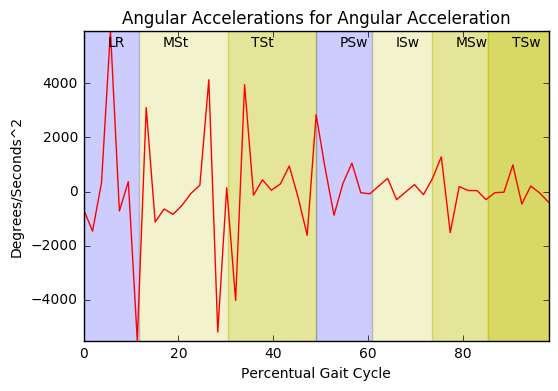

In [42]:
    av_img = aa 
    av_dom = 100 * np.arange(0, len(av_img))/np.float(len(av_img))
    lr_i = 0
    lr_f = av_dom.max() * 0.12 
    mst_i = lr_f
    mst_f = av_dom.max() * 0.31
    tst_i = mst_f
    tst_f = av_dom.max() * 0.50
    psw_i = tst_f
    psw_f = av_dom.max() * 0.62
    isw_i = psw_f
    isw_f = av_dom.max() * 0.75
    msw_i = isw_f
    msw_f = av_dom.max() * 0.87
    tsw_i = msw_f
    tsw_f = av_dom.max() * 1

    import matplotlib.pyplot as plt
    fig = plt.figure(1)

    plt.subplot(1,1,1)
    plt.title("Angular Accelerations for %s" % "Angular Acceleration")
    plt.ylabel ("Degrees/Seconds^2")
    plt.xlabel ("Percentual Gait Cycle")
    plt.axis([0, av_dom.max(), av_img.min(), av_img.max()])
    curve_av, = plt.plot(av_dom, av_img, 'r')
    plt.axvspan(xmin = lr_i, xmax=lr_f, ymin =0, ymax=1, alpha = 0.2, color='b')
    plt.annotate('LR', xy=(lr_i + 5, av_img.max() * 0.90))  
    plt.axvspan(xmin = mst_i, xmax=mst_f, ymin =0, ymax=1, alpha = 0.2, color='y')
    plt.annotate('MSt', xy=(mst_i + 5, av_img.max() * 0.90))  
    plt.axvspan(xmin = tst_i, xmax=tst_f, ymin =0, ymax=1, alpha = 0.4, color='y')
    plt.annotate('TSt', xy=(tst_i + 5, av_img.max() * 0.90))  
    plt.axvspan(xmin = psw_i, xmax=psw_f, ymin =0, ymax=1, alpha = 0.2, color='b')
    plt.annotate('PSw', xy=(psw_i + 5, av_img.max() * 0.90))  
    plt.axvspan(xmin = isw_i, xmax=isw_f, ymin =0, ymax=1, alpha = 0.2, color='y')
    plt.annotate('ISw', xy=(isw_i + 5, av_img.max() * 0.90))  
    plt.axvspan(xmin = msw_i, xmax=msw_f, ymin =0, ymax=1, alpha = 0.4, color='y')
    plt.annotate('MSw', xy=(msw_i + 5, av_img.max() * 0.90))  
    plt.axvspan(xmin = tsw_i, xmax=tsw_f, ymin =0, ymax=1, alpha = 0.6, color='y')
    plt.annotate('TSw', xy=(tsw_i + 5, av_img.max() * 0.90))  

    plt.show()


## Vetor de features para classificação $X_c = [a, av, aa, C]$
#### $a \rightarrow$ ângulo; $av \rightarrow$ velocidade angular; $aa \rightarrow$ aceleração angular; $C \rightarrow$ indice de classificação
## Indice de classificação $"c"$:
#### $C = 0 \rightarrow$ Marcha normal;
#### $C = 1 \rightarrow$ Marcha de subida de escada;
#### $C = 2 \rightarrow$ Marvha de descidade escada.

In [43]:
print a.shape, av.shape, aa.shape
len_xc = len(a)-2

(55,) (54,) (53,)


In [44]:
Xcp = np.hstack(
                (a[2:].reshape((len_xc,1)),
                 av[1:].reshape((len_xc,1))))

In [45]:
Xcp = np.hstack(
                (Xcp.reshape((len_xc,2)),
                 aa.reshape((len_xc,1))))

In [46]:
Xcp = np.hstack(
                (Xcp.reshape((len_xc,3)),
                 l_a[2:].reshape((len_xc,1))))

In [47]:
Xcp = np.hstack(
                (Xcp.reshape((len_xc,4)),
                 l_av[1:].reshape((len_xc,1))))

In [48]:
Xcp = np.hstack(
                (Xcp.reshape((len_xc,5)),
                 l_aa.reshape((len_xc,1))))

In [49]:
Xcp = np.hstack(
                (Xcp.reshape((len_xc,6)),
                 pos_foot_r[2:].reshape((len_xc,1))))

In [50]:
Xcp = np.hstack(
                (Xcp.reshape((len_xc,7)),
                 pos_foot_l[2:].reshape((len_xc,1))))

In [51]:
vz_r = velocities3d[1:,2]   # Velocidade no eixo z
vz_l = l_velocities3d[1:,2] # Velocidade no eixo z

In [52]:
Xcp = np.hstack(
                (Xcp.reshape((len_xc,8)),
                 vz_r.reshape((len_xc,1))))

In [53]:
Xcp = np.hstack(
                (Xcp.reshape((len_xc,9)),
                 vz_l.reshape((len_xc,1))))

### Adiciando coluna de classificação

In [54]:
C = (np.ones(len_xc)*1).reshape((len_xc,1))

In [55]:
Xc = np.hstack(
                (Xcp.reshape((len_xc,10)),
                 C.reshape((len_xc,1))))

In [56]:
Xc.shape

(53, 11)

In [57]:
## salvando em arquivo na pasta <classifier_data>
from Data_Savior_J import save_it_now
save_it_now(Xc, "./classifier_data/walk1U.data")

Saved to file


# Checks for Nan

In [58]:
Nan = np.isnan(Xc)
Nan  

array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, Fal